# Imports

In [42]:
import warnings
warnings.filterwarnings('ignore')

import osmnx as ox
import networkx as nx
import geojson as gj
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Point
from geopandas import GeoDataFrame
from keplergl import KeplerGl
import geopandas
from geopandas import datasets, GeoDataFrame, read_file

from sklearn.mixture import GaussianMixture
from sklearn import mixture
import datetime as dt
import itertools

## import the data

In [2]:
# Data snapshot from 3/11/2022
# https://donnees.montreal.ca/ville-de-montreal/actes-criminels
data = pd.read_csv("data/montreal_crime_data.csv", encoding='latin1')
pdq = read_file("data/limitespdq.csv", encoding='latin1')

## Preprocessing & exploring

In [3]:
data.columns = data.columns.str.lower()

In [4]:
gdf = geopandas.GeoDataFrame(
    data, geometry=geopandas.points_from_xy(data.longitude, data.latitude))
gdf.head()

,categorie,date,quart,pdq,x,y,longitude,latitude,geometry
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,POINT (-73.62678 45.56778)
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,POINT (-73.62678 45.56778)
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122,POINT (-73.68593 45.51912)
3,Méfait,2017-07-21,jour,21.0,0.000000,0.000000e+00,-76.237290,0.000000,POINT (-76.23729 0.00000)
4,Méfait,2017-07-29,jour,12.0,0.000000,0.000000e+00,-76.237290,0.000000,POINT (-76.23729 0.00000)


In [5]:
pdq.head()

,PDQ,NOM_PDQ,WKT,geometry
0,1,PDQ-1,MULTIPOLYGON (((-73.8404999999329 45.456900000...,"MULTIPOLYGON (((-73.84050 45.45690, -73.84220 ..."
1,3,PDQ-3,MULTIPOLYGON (((-73.9396999999881 45.470100000...,None
2,4,PDQ-4,MULTIPOLYGON (((-73.8158999998122 45.502599999...,"MULTIPOLYGON (((-73.81590 45.50260, -73.81590 ..."
3,5,PDQ-5,MULTIPOLYGON (((-73.7227999996394 45.432000000...,"MULTIPOLYGON (((-73.72280 45.43200, -73.72270 ..."
4,7,PDQ-7,MULTIPOLYGON (((-73.6723999995738 45.532500000...,"MULTIPOLYGON (((-73.67240 45.53250, -73.67150 ..."


In [6]:
gdf.crs = pdq.crs

In [7]:
join_left_df = gdf.sjoin(pdq, how="left")

In [8]:
data = join_left_df.dropna()

#### Checking for NaN values

In [9]:
pd.DataFrame(data.isnull().sum(), columns=['Nb of missing values']).rename_axis('Feature')
print('ok')

ok


## Meta information of data

In [10]:
print(f"Shape of data is: {data.shape}")

Shape of data is: (176781, 13)


In [11]:
pd.DataFrame(data.dtypes, columns=['Datatype']).rename_axis('Columns')
print('ok')

ok


## Data cleaning

#### Converting date feature to datatime format

In [12]:
data['date'] = data['date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))

In [13]:
data['date'] = np.where(data['quart']=='jour', data['date'] + ' 11:00:00', data['date'])
data['date'] = np.where(data['quart']=='soir', data['date'] + ' 19:00:00', data['date'])
data['date'] = np.where(data['quart']=='nuit', data['date'] + ' 23:59:59', data['date'])

In [14]:
data['date'] = pd.to_datetime(data['date'])

In [15]:
datatypes = pd.DataFrame(data.dtypes, columns=['Datatype']).rename_axis('Columns')
datatypes

,Datatype
Columns,
categorie,object
date,datetime64[ns]
quart,object
pdq,float64
x,float64
y,float64
longitude,float64
latitude,float64
geometry,geometry


In [16]:
coordinates = [Point(xy) for xy in zip(data["longitude"], data["latitude"])]
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(data, crs=crs, geometry=coordinates)

In [17]:
to_drop = ['longitude', 'latitude']
data.drop(to_drop, inplace=True, axis=1)

In [108]:
from datetime import date
import calendar
day_of_week = []
year = []
for date in data['date']:
    day_of_week.append(calendar.day_name[date.weekday()])
    year.append(date.year)
data['day_of_week'] = day_of_week
data['year'] = year

In [109]:
def add_is_weekend(df):
    res = []
    for day in df['day_of_week']:
        if day in ['Saturday', 'Sunday']: res.append(True)
        else: res.append(False)
    df['is_weekend'] = res

In [110]:
add_is_weekend(data)
data.head()

,categorie,date,quart,pdq,x,y,geometry,index_right,PDQ,NOM_PDQ,WKT,day_of_week,is_weekend,year
0,Vol de véhicule à moteur,2018-09-13 11:00:00,jour,30.0,294904.159001,5.047549e+06,POINT (-73.62678 45.56778),18.0,30,PDQ-30,MULTIPOLYGON (((-73.6140999998897 45.579800000...,Thursday,False,2018
1,Vol de véhicule à moteur,2018-04-30 11:00:00,jour,30.0,294904.159001,5.047549e+06,POINT (-73.62678 45.56778),18.0,30,PDQ-30,MULTIPOLYGON (((-73.6140999998897 45.579800000...,Monday,False,2018
2,Vol de véhicule à moteur,2018-09-01 23:59:59,nuit,7.0,290274.565000,5.042150e+06,POINT (-73.68593 45.51912),4.0,7,PDQ-7,MULTIPOLYGON (((-73.6723999995738 45.532500000...,Saturday,True,2018
6,Méfait,2017-07-30 11:00:00,jour,38.0,297654.715002,5.041877e+06,POINT (-73.59146 45.51678),22.0,38,PDQ-38,MULTIPOLYGON (((-73.5741999996826 45.541400000...,Sunday,True,2017
8,Vol dans / sur véhicule à moteur,2017-08-01 11:00:00,jour,39.0,294259.780993,5.051450e+06,POINT (-73.63512 45.60287),23.0,39,PDQ-39,MULTIPOLYGON (((-73.6032999996096 45.610899999...,Tuesday,False,2017


### Get rid of unreal positions

In [111]:
print(data.shape)

(176781, 14)


In [112]:
# Filter out cases without location values
data = data.loc[(data['x'] >= 10)]
data = data.loc[(data['y'] >= 10)]
print(data.shape)

(176781, 14)


In [113]:
# max/min values with x/y
nord, sud, est, ouest = max(data['y']), min(data['y']), min(data['x']), max(data['x'])
print(nord, sud, est, ouest)

5062496.463006 5029291.475001249 268109.610009768 306389.863


### Postes de police

In [114]:
print('Nb de postes de police dans les données:', len(np.unique(data['pdq'])))
print('Nb de poste de police ', pdq.shape[0])
print('Conclusion: on a pas le même nombre de poste de police puisque les données ne sont pas mis à jour en même temps')

Nb de postes de police dans les données: 34
Nb de poste de police  30
Conclusion: on a pas le même nombre de poste de police puisque les données ne sont pas mis à jour en même temps


## Visualization

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

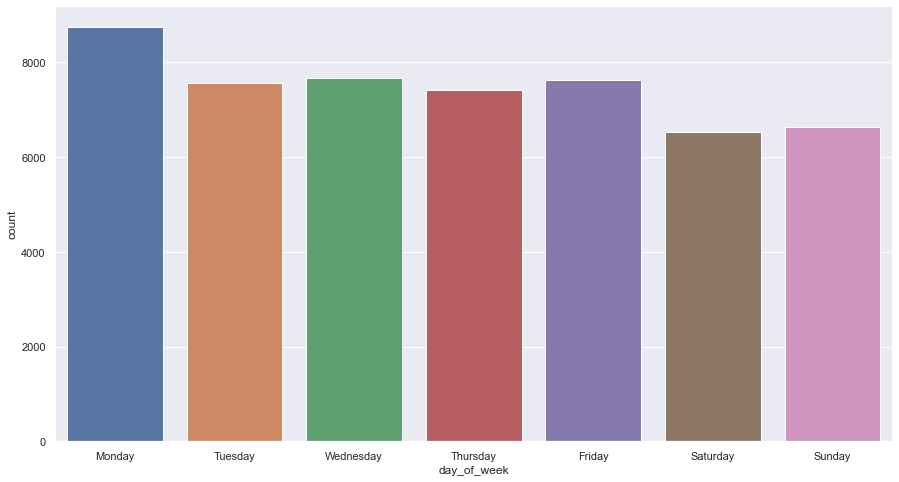

In [115]:
from pandas.api.types import CategoricalDtype
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
data['day_of_week'] = data['day_of_week'].astype(cat_type)
sns.set(rc = {'figure.figsize':(15,8)})
data_introd = data[data['categorie'] == 'Introduction']
sns.countplot(x="day_of_week", data=data_introd)

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

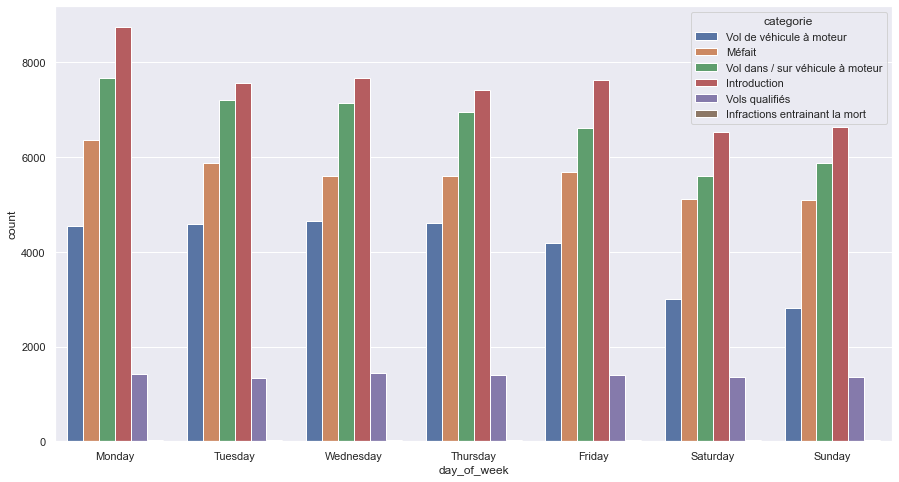

In [116]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="day_of_week", hue="categorie", data=data)

<AxesSubplot:xlabel='year', ylabel='count'>

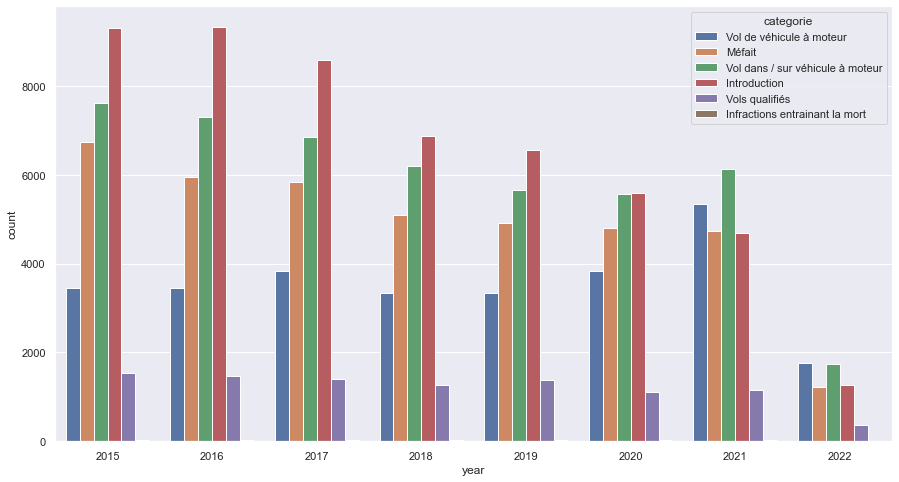

In [117]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x="year", hue="categorie", data=data)

In [118]:
year_wise_trend = data.groupby('year').count().drop(['date', 'quart', 'pdq', 'x', 'y', 'geometry',
       'index_right', 'PDQ', 'NOM_PDQ', 'WKT', 'day_of_week', 'is_weekend'],  
                                                  axis=1).rename({'categorie':"Case Reported"}, axis=1)

fig = px.line(year_wise_trend.iloc[:-1], 
              x = year_wise_trend.index[:-1],
              y = 'Case Reported',
              labels = {'x': 'Year'},
              text = year_wise_trend.index[:-1],
              title = "<b>Trend of Crime from 2015 to 2021</b>",
              template = 'ggplot2')

fig.update_traces(textposition="bottom right")
fig.show()

In [37]:
from shapely.geometry import Point, mapping, shape
for coord in data['geometry']:
    res = []
    mapping(coord)
    #{'type': 'Point', 'coordinates': (3.0, 4.0)}
    # and the reverse
    shape(mapping(coord))
    res.append(coord)
print(res)
res = pd.DataFrame(res)

In [ ]:
from keplergl import KeplerGl
map1 = KeplerGl(height=500)
map1
map1.add_data(data=data, name='Montreal\'s crime plot')

In [ ]:
map1.save_to_html(file_name='mtl_crime-customize.html')

In [ ]:
state = ox.geocode_to_gdf('Quebec, CA')
ax = ox.project_gdf(state).plot(fc='gray', ec='none')
_ = ax.axis('off')

In [ ]:
# Defining the map boundaries 
north, east, south, west = 45.6923, -73.3736, 45.3874, -73.9730  
# Downloading the map as a graph object 
G = ox.graph_from_bbox(north, south, east, west, network_type = 'drive')  
# Plotting the map graph 
ox.plot_graph(G)

In [ ]:
origin_point = (45.5173538,-73.58212888)
destination_point = (45.539385081961676,-73.54099988937377)
# get the nearest nodes to the locations 
origin_node = ox.get_nearest_node(G, origin_point) 
destination_node = ox.get_nearest_node(G, destination_point)
# Finding the optimal path 
route = nx.shortest_path(G, origin_node, destination_node, weight = 'length')
print(route)

In [ ]:
#store long, lat
long = [] 
lat = []  
for i in route:
     point = G.nodes[i]
     long.append(point['x'])
     lat.append(point['y'])

In [ ]:
#store long, lat
""""string = ""{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "vendor":  "A"
      },
      "geometry": {
        "type": "LineString",
        "coordinates": [
          [-74.20986, 40.81773, 0],
          [-74.20987, 40.81765, 0],
          [-74.20998, 40.81746, 0]
        ]
      }
    }
  ]
}"""
first_string = "{\"type\": \"FeatureCollection\",\"features\": [{\"type\": \"Feature\",\"properties\": {\"vendor\":  \"A\"},\"geometry\": {\"type\": \"LineString\",\"coordinates\": [ "
coordinates = ""
long = [] 
lat = []  
for i in route: 
    point = G.nodes[i]
    print(point)
    long.append(point['x'])
    lat.append(point['y'])
    long_lat = "[" + str(point['x']) + "," + str(point['y']) + "],\n"
    coordinates += long_lat
final_string = "]}}]}"
string = first_string + coordinates + final_string
print(string)
print(len(route))
file2write=open("pathh",'w')
file2write.write(string)
file2write.close()

In [ ]:
def plot_path(lat, long, origin_point, destination_point):
  
    # adding the lines joining the nodes
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'purple')))
    # adding source marker
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()

In [ ]:
plot_path(lat, long, origin_point, destination_point)

# GMM

### Feature selection

In [136]:
features = ['x', 'y']

X = data[features]

In [137]:
means = X.mean(axis=0)
X = X - means

In [138]:
X = X.sample(50000)

In [139]:
gmm = GaussianMixture(n_components=100, covariance_type="full")
gmm.fit(X)

GaussianMixture(n_components=100)

In [146]:
X.iloc[:, 0]

129993     2941.182542
92718    -14147.899462
31087      3053.844541
25830     -6435.325461
84577      3396.131542
              ...     
22133      7549.396536
83702     -2192.839466
112155      913.814544
3408     -13773.931459
41584     -6986.490475
Name: x, Length: 50000, dtype: float64

[[-4685842.04550898 -4686460.43018993 -4687078.85621463 ...
  -4746017.85606681 -4746640.25109163 -4747262.6874602 ]
 [-4685773.28637194 -4686391.67643093 -4687010.10783366 ...
  -4745949.61859916 -4746572.01900201 -4747194.46074861]
 [-4685704.70914788 -4686323.1045849  -4686941.54136567 ...
  -4745881.56304447 -4746503.96882536 -4747126.41595   ]
 ...
 [-4680019.39601054 -4680638.30236087 -4681257.25005496 ...
  -4740245.80849857 -4740868.72519278 -4741491.68323073]
 [-4679968.28243171 -4680587.19416008 -4681206.1472322  ...
  -4740195.21658913 -4740818.13866137 -4741441.10207736]
 [-4679917.35076586 -4680536.26787226 -4681155.22632242 ...
  -4740144.80659266 -4740767.73404293 -4741390.70283696]]


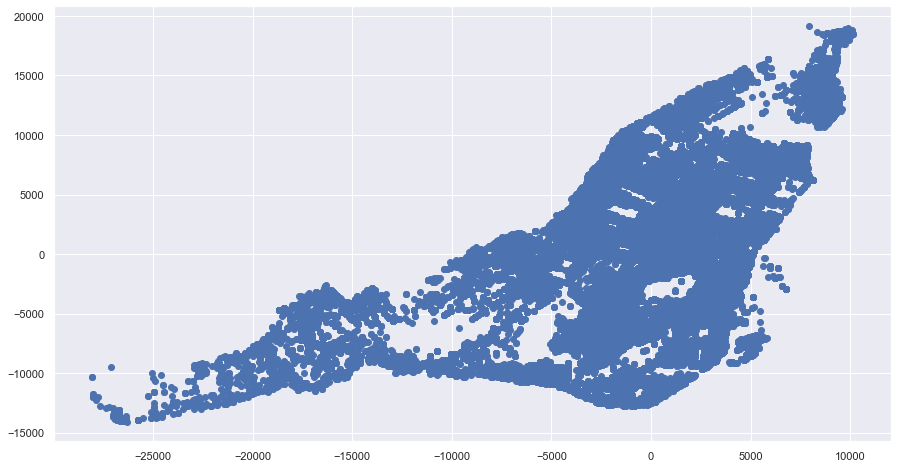

In [162]:
mesh_x, mesh_y = np.meshgrid(np.linspace(sud, nord, 100), np.linspace(ouest, est, 100))
XX = np.array([mesh_x.ravel(), mesh_y.ravel()]).T
Z = gmm.score_samples(XX)
Z = Z.reshape((100, 100))
print(Z)
# plt.contour(mesh_x, mesh_y, Z)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1])
plt.show()

In [126]:
cluster = EM.predict(X)
# cluster_p = EM.predict_proba(X)
# cluster_p

In [135]:
cluster_p = gmm.predict_proba(X)
print(np.max(cluster_p, axis=1).shape)

ValueError: X has 3 features, but GaussianMixture is expecting 2 features as input.

In [80]:
# print('silhouette', silhouette_score(X, cluster))

In [133]:
X['cluster'] = np.max(cluster_p, axis=1)

<function matplotlib.pyplot.show(close=None, block=None)>

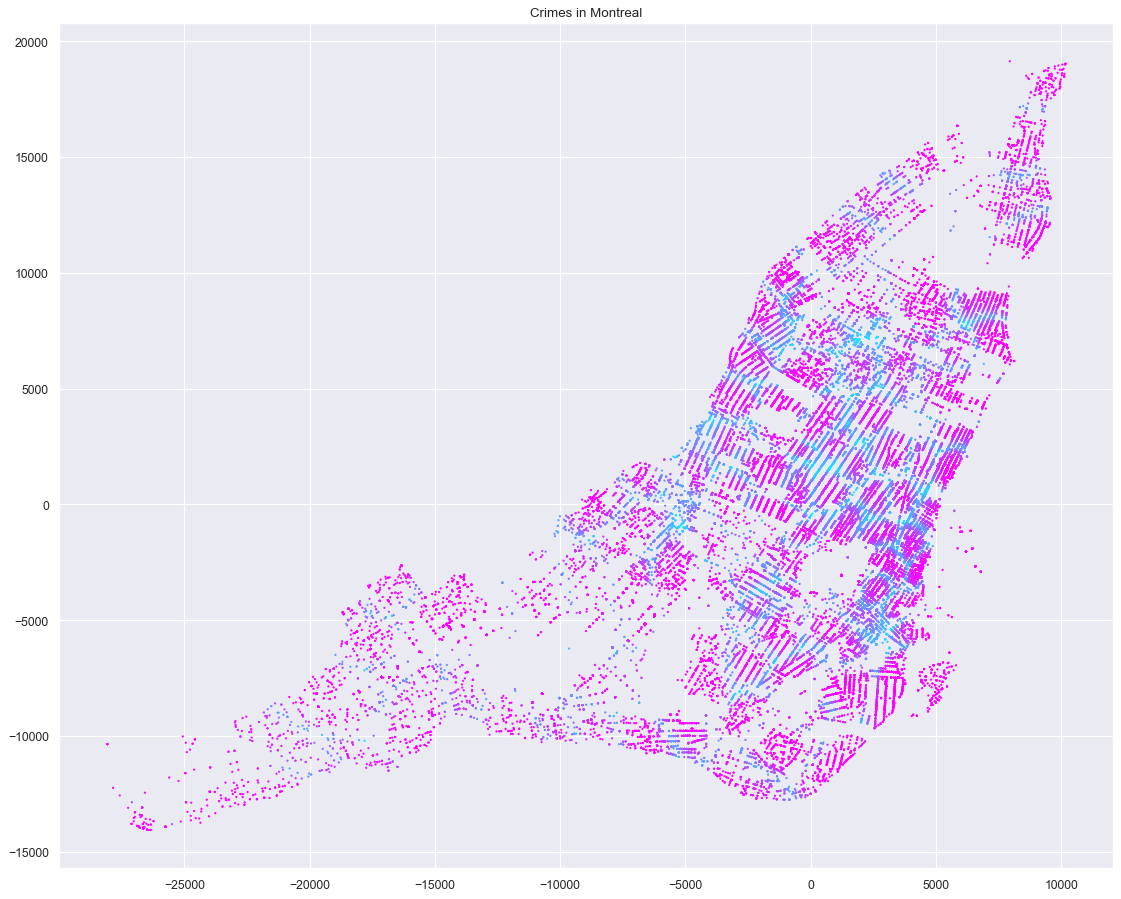

In [134]:
# Data plot locations
plt.figure(figsize = (17, 14), dpi = 80)
plt.scatter(X['x'], X['y'], s=1, marker='o', c=X['cluster'], cmap='cool')
plt.title('Crimes in Montreal')
plt.show

### Associer des poids aux crimes

In [ ]:
# https://www150.statcan.gc.ca/n1/pub/85-004-x/2009001/part-partie1-eng.htm

In [ ]:
# np.unique(data['categorie'], return_counts=True)

In [ ]:
# data_weights = data
# data_weights = data_weights.replace({'Vol de véhicule à moteur': 3, 
#                          'Vol dans / sur véhicule à moteur': 1, 
#                          'Infractions entrainant la mort': 10,
#                          'Introduction': 3,
#                          'Méfait': 3,
#                          'Vols qualifiés': 4
                         
# })

## GMM associé à des points

In [97]:
data.head()

,categorie,date,quart,pdq,x,y,geometry,index_right,PDQ,NOM_PDQ,WKT,day_of_week,is_weekend
0,Vol de véhicule à moteur,2018-09-13 11:00:00,jour,30.0,294904.159001,5.047549e+06,POINT (-73.62678 45.56778),18.0,30,PDQ-30,MULTIPOLYGON (((-73.6140999998897 45.579800000...,Thursday,False
1,Vol de véhicule à moteur,2018-04-30 11:00:00,jour,30.0,294904.159001,5.047549e+06,POINT (-73.62678 45.56778),18.0,30,PDQ-30,MULTIPOLYGON (((-73.6140999998897 45.579800000...,Monday,False
2,Vol de véhicule à moteur,2018-09-01 23:59:59,nuit,7.0,290274.565000,5.042150e+06,POINT (-73.68593 45.51912),4.0,7,PDQ-7,MULTIPOLYGON (((-73.6723999995738 45.532500000...,Saturday,True
6,Méfait,2017-07-30 11:00:00,jour,38.0,297654.715002,5.041877e+06,POINT (-73.59146 45.51678),22.0,38,PDQ-38,MULTIPOLYGON (((-73.5741999996826 45.541400000...,Sunday,True
8,Vol dans / sur véhicule à moteur,2017-08-01 11:00:00,jour,39.0,294259.780993,5.051450e+06,POINT (-73.63512 45.60287),23.0,39,PDQ-39,MULTIPOLYGON (((-73.6032999996096 45.610899999...,Tuesday,False


In [ ]:
# features = ['x', 'y', 'categorie']

# X = data_weights[features]

In [ ]:
# EM = GaussianMixture(n_components=30)
# EM.fit(X)
# cluster = EM.predict(X)
# print(np.unique(cluster, return_counts=True))
# # cluster_p = EM.predict_proba(X)
# # cluster_p

In [ ]:
# X['cluster'] = cluster

In [ ]:
# # Data plot locations
# plt.figure(figsize = (10, 6), dpi = 80)
# plt.scatter(X['x'], X['y'], s=1, marker='o', c=X['cluster'], cmap='viridis')
# plt.title('Crimes in Montreal')
# plt.show

In [ ]:
for category in np.unique(data.categorie):
#     for quart in np.unique(data.quart):
        cat = (data.categorie == category)
#         qrt = (data.quart == quart)
        pgx = (data.x > 1000)
        plx = (data.x < 1e6)
        pgy = (data.y > 1000)
        split_data = data[cat*pgx*plx*pgy]
        
        # temps en float
        mindate = data.date.min()
        def timetofloat(d):
            deltas = (d - mindate)  / np.timedelta64(1,'D')
            return deltas
        
        # vecteurs
        coords = np.vstack((split_data.x, split_data.y, timetofloat(split_data.date))).T
        
        coords = np.unique([tuple(row) for row in coords], axis=0)
        
        ncomponents = min(100, len(coords))
        classifier = GaussianMixture(n_components=ncomponents, covariance_type="full")
        
        classifier.fit(coords)
        
        minx = data[pgx*plx*pgy].x.min()
        maxx = data[pgx*plx*pgy].x.max()
        miny = data[pgx*plx*pgy].y.min()
        maxy = data[pgx*plx*pgy].y.max()
        maxdatef = timetofloat(data.date.max())
        testdata = np.array([[ 294904, 5047548, maxdatef],
                            [ 294904, 5047548, maxdatef],
                            [ 290274, 5042150, maxdatef],
                            [ 299344, 5040364, maxdatef],
                            [ 294968, 5047651, maxdatef],
                            [ 291553, 5035569, maxdatef]])
        
        #print(classifier.means_)

        colors = []
        for i in range(ncomponents):
            colors.append(tuple(np.random.uniform(0.3, 1, size=3)))
    
        #dcolors = [colors[i] for i in classifier.predict(testdata)]
        #dcolors = [colors[i] for i in classifier.predict(coords)]


        #ax = plt.gca()
        #plt.clf()
        #plt.cla()
        #plt.close()
        #plt.scatter(testdata[:,0], testdata[:,1], c=dcolors, alpha=0.8)
        #plt.scatter(coords[:,0], coords[:,1], c=dcolors, alpha=0.8)
        #plt.show()
        
        fig = plt.figure(figsize = (17, 14), dpi = 80)
        ax = plt.axes(projection='3d')
        
        resolution = 50
        plotx = np.linspace(minx, maxx, num=resolution)
        ploty = np.linspace(miny, maxy, num=resolution)
        
        
        X, Y = np.meshgrid(plotx, ploty)    #grid de points pour le plot 3D, resolution^2 points
        T = maxdatef*np.ones(shape=X.shape) #T c'est le moment auquel on fait la prediction
        
        cutoff = -50000000000
        Z = []
        for x in plotx:
            zprime = []
            for y in ploty:
                val = classifier.score_samples(np.array([[x,y,maxdatef]]))[0]
                zprime.append(val if val>cutoff else cutoff)
            Z.append(zprime)
        
        Z = np.array(Z)
        #Z = classifier.predict_proba(np.vstack([X,Y,T]).T) #avoir la prediction pour chaque point
        
        ax.contour3D(X, Y, Z, 50, cmap='binary')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title('3D contour')
        
#         ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False)
        print('choix:', category, quart)
        plt.show()

In [ ]:
for category in np.unique(data.categorie):
    for quart in np.unique(data.quart):
        cat = (data.categorie == category)
        qrt = (data.quart == quart)
        pgx = (data.x > 1000)
        plx = (data.x < 1e6)
        pgy = (data.y > 1000)
        split_data = data[cat*qrt*pgx*plx*pgy]
        
        # temps en float
        mindate = data.date.min()
        def timetofloat(d):
            deltas = (d - mindate)  / np.timedelta64(1,'D')
            return deltas
        
        # vecteurs
        coords = np.vstack((split_data.x, split_data.y, timetofloat(split_data.date))).T
        
        coords = np.unique([tuple(row) for row in coords], axis=0)
        
        ncomponents = min(100, len(coords))
        classifier = GaussianMixture(n_components=ncomponents, covariance_type="full")
        
        classifier.fit(coords)
        
        minx = data[pgx*plx*pgy].x.min()
        maxx = data[pgx*plx*pgy].x.max()
        miny = data[pgx*plx*pgy].y.min()
        maxy = data[pgx*plx*pgy].y.max()
        maxdatef = timetofloat(data.date.max())
        testdata = np.array([[ 294904, 5047548, maxdatef],
                            [ 294904, 5047548, maxdatef],
                            [ 290274, 5042150, maxdatef],
                            [ 299344, 5040364, maxdatef],
                            [ 294968, 5047651, maxdatef],
                            [ 291553, 5035569, maxdatef]])
        
        #print(classifier.means_)

        colors = []
        for i in range(ncomponents):
            colors.append(tuple(np.random.uniform(0.3, 1, size=3)))
    
        #dcolors = [colors[i] for i in classifier.predict(testdata)]
        #dcolors = [colors[i] for i in classifier.predict(coords)]


        #ax = plt.gca()
        #plt.clf()
        #plt.cla()
        #plt.close()
        #plt.scatter(testdata[:,0], testdata[:,1], c=dcolors, alpha=0.8)
        #plt.scatter(coords[:,0], coords[:,1], c=dcolors, alpha=0.8)
        #plt.show()
        
        fig = plt.figure(figsize = (17, 14), dpi = 80)
        ax = plt.axes(projection='3d')
        
        resolution = 100
        plotx = np.linspace(minx, maxx, num=resolution)
        ploty = np.linspace(miny, maxy, num=resolution)
        
        
        X, Y = np.meshgrid(plotx, ploty)    #grid de points pour le plot 3D, resolution^2 points
        T = maxdatef*np.ones(shape=X.shape) #T c'est le moment auquel on fait la prediction
        
        Z = []
        for x in plotx:
            zprime = []
            for y in ploty:
                val = classifier.score_samples(np.array([[x,y,maxdatef]]))[0]
                zprime.append(val)
            Z.append(zprime)
        
        temp = sorted(Z, reverse=True)
        cutoff = temp[10]
        Z = [z for z in zprime if z > cutoff]
        Z = np.array(Z)
        #Z = classifier.predict_proba(np.vstack([X,Y,T]).T) #avoir la prediction pour chaque point
        
        ax.contour3D(X, Y, Z, 50, cmap='binary')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title('3D contour')
        
        print('choix:', category, quart)
        plt.show()